In [1]:
import pandas as pd
import numpy as np
import random
from gensim.models.doc2vec import Doc2Vec
from mofgraph2vec.featurize.mof2doc import MOF2doc
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import scipy.stats as ss

import matplotlib as mpl
mpl.rcParams["font.size"] = 18

/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/l

In [2]:
df = pd.read_csv("../data/md-core-xq.csv").set_index("info.name")

2005: offline-run-20230828_140847-804v5w59 (0.99702/0.36303) \
2006: offline-run-20230828_140512-by30t6df (0.99236/0.3689) \
2007: offline-run-20230828_140235-z7fg9qlr (0.97471/0.62817) \
2008: offline-run-20230828_140113-kdq418oj (0.96981/0.51121) \
2009: offline-run-20230828_135947-edducouk (0.94738/0.4292) \
2010: offline-run-20230828_135705-24n9b5v2 (0.92114/0.59706) \
2011: offline-run-20230828_135604-lpoaccgc (0.88867/0.62615) \
2012: offline-run-20230828_135213-ho8t8fek (0.84198/0.52042) \
2013: offline-run-20230828_124657-q8y9ldn5 (0.81389/0.42076) \
2014: offline-run-20230829_133546-ktcasehg (0.77532/0.40128) \
2015: offline-run-20230828_122317-3vc1832t (0.7516/0.46514)

In [3]:
test_r2 = [0.36303, 0.3689, 0.62817, 0.51121, 0.4292, 0.59706, 0.62615, 0.52042, 0.42076, 0.40128, 0.46514]

In [4]:
test_corpus_config = {
  "embed_label": False,
  "label_path": "../../data/md-core-xq.csv",
  "labels_to_embed": ["outputs.logKH_CO2", "outputs.logKH_CH4"],
  "id_column": "info.name",
  "wl_step": 2,
  "n_components": 2,
  "use_hash": False,
  "writing_style": "paragraph",
  "composition": False,
  "mode": "all",
  "embed_cif": False
}

In [5]:
def cosine(a, b):
    cos = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos

In [6]:
def load_pretrained(model_path):
    model = Doc2Vec.load(model_path)
    co2_kh_vecs = [model.dv["outputs.xq.logKH_CO2_%s" %i] for i in range(10)]
    n2_kh_vecs= [model.dv["outputs.xq.logKH_N2_%s" %i] for i in range(10)]
    ch4_kh_vecs = [model.dv["outputs.logKH_CH4_%s" %i] for i in range(10)]
    ch4_lowp_vecs = [model.dv["outputs.pure_uptake_methane_298.00_580000_%s" %i] for i in range(10)]
    ch4_highp_vecs = [model.dv["outputs.pure_uptake_methane_298.00_6500000_%s" %i] for i in range(10)]
    
    return model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, ch4_lowp_vecs, ch4_highp_vecs

In [7]:
def get_test_data(test_cif_path, model):
    test_corpus = {}
    test_ds = MOF2doc(cif_path=test_cif_path, **test_corpus_config).get_documents()
    for dp in test_ds:
        if dp.tags[0] in list(df.index):
            test_corpus.update(
                {
                    dp.tags[0]: model.infer_vector(dp.words, epochs=300)
                }
            )
    return test_corpus

In [8]:
def get_similarities(test_corpus, bench_vec):
    test_cosine = {}
    for key, vec in test_corpus.items():
        test_cosine.update(
            {   
                key: [cosine(bench, vec) for bench in bench_vec]
            }
        )
    return test_cosine

In [9]:
def select_top_n(test_similarities, test_years, top_percent):
    topn = int(len(test_similarities)*top_percent)
    # recommendation from similarity
    similarities = np.array([np.array(sim).mean() for _, sim in test_similarities.items()])
    top_indices = similarities.argsort()[-topn:][::-1]
    recommendations = []
    for index in top_indices:
        recommendations.append((list(test_similarities)[index], similarities[index]))

    # topN from simulation
    names = df[df["info.year"].isin(test_years)]["info.name"].values
    #simulations = df[df["info.year"].isin(test_years)][recom_target].values
    simu_ch4 = df[df["info.year"].isin(test_years)]["outputs.logKH_CH4"].values
    simu_co2 = df[df["info.year"].isin(test_years)]["outputs.logKH_CO2"].values
    simu_n2 = df[df["info.year"].isin(test_years)]["outputs.xq.logKH_N2"].values
    simulations = df[df["info.year"].isin(test_years)]["outputs.pure_uptake_methane_298.00_6500000".values]
    top_simulation = simulations.argsort()[-topn:][::-1]
    true_top = []
    top_names = []
    for index in top_simulation:
        true_top.append((names[index], simulations[index]))
        top_names.append(names[index])
    
    # random selection 
    rand_acc_time = []
    time = 0
    while time < 5:
        random_names = random.choices(names, k=topn)
        true_or_false = [True if name in top_names else False for name in random_names]
        rand_acc_time.append(sum(true_or_false)/len(true_or_false))
        time += 1

    true_or_false = [True if name in top_names else False for name, sim in recommendations]
    recm_acc = sum(true_or_false)/len(true_or_false)

    rand_acc = np.mean(rand_acc_time)

    return recm_acc, rand_acc

In [10]:
df["outputs.selectivity"] = df['outputs.xq.logKH_CO2'].values - df['outputs.xq.logKH_N2'].values

In [11]:
def cal_spearman(test_cosines):
    test_sim = {name: np.mean(x) for name, x in test_cosines.items()}
    model_v = [sim for i, sim in test_sim.items()]
    simul_v = [df.loc[i, "outputs.pure_uptake_methane_298.00_6500000"] for i, sim in test_sim.items()]

    return spearmanr(model_v, simul_v)[0]

In [12]:
topP = 0.3

In [13]:
# cutoff 2005
model_path = "../experiments/workflow/wandb/offline-run-20230828_140847-804v5w59/tmp/embedding_model.pt"
model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, ch4_lowp_vecs, ch4_highp_vecs  = load_pretrained(model_path)

bench_vecs = ch4_highp_vecs[-1] + ch4_highp_vecs[-2] + ch4_highp_vecs[-3]
"""
bench_vecs = [
    co2_kh_vecs[-1] - n2_kh_vecs[-1],
    co2_kh_vecs[-1] - n2_kh_vecs[-2],
    co2_kh_vecs[-2] - n2_kh_vecs[-1],
    co2_kh_vecs[-2] - n2_kh_vecs[-2],
    co2_kh_vecs[-3] - n2_kh_vecs[-1],
    co2_kh_vecs[-3] - n2_kh_vecs[-2],
]
"""
sp_2005_sel = []
for test_years in [
    [2006], [2006, 2007], 
    [2006, 2007, 2008], [2006, 2007, 2008, 2009], 
    [2006, 2007, 2008, 2009, 2010], 
    [2006, 2007, 2008, 2009, 2010, 2011], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2005_sel.append(cal_spearman(test_cosines))

 50%|█████     | 31/62 [00:00<00:00, 303.72it/s]

100%|██████████| 1837/1837 [00:05<00:00, 348.48it/s]


In [15]:
# cutoff 2006
model_path = "../experiments/workflow/wandb/offline-run-20230828_140512-by30t6df/tmp/embedding_model.pt"
model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, ch4_lowp_vecs, ch4_highp_vecs  = load_pretrained(model_path)

"""
bench_vecs = [
    co2_kh_vecs[-1] - n2_kh_vecs[-1],
    co2_kh_vecs[-1] - n2_kh_vecs[-2],
    co2_kh_vecs[-2] - n2_kh_vecs[-1],
    co2_kh_vecs[-2] - n2_kh_vecs[-2],
    co2_kh_vecs[-3] - n2_kh_vecs[-1],
    co2_kh_vecs[-3] - n2_kh_vecs[-2],
]
"""
sp_2006_sel = []
for test_years in [
    [2007], 
    [2007, 2008], [2007, 2008, 2009], 
    [2007, 2008, 2009, 2010], 
    [2007, 2008, 2009, 2010, 2011], 
    [2007, 2008, 2009, 2010, 2011, 2012], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2006_sel.append(cal_spearman(test_cosines))

100%|██████████| 1775/1775 [00:07<00:00, 226.02it/s]


In [16]:
# cutoff 2007 
model_path = "../experiments/workflow/wandb/offline-run-20230828_140235-z7fg9qlr/tmp/embedding_model.pt"
model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, _, ch4_highp_vecs  = load_pretrained(model_path)
bench_vecs = ch4_highp_vecs[-1] + ch4_highp_vecs[-2] + ch4_highp_vecs[-3]
"""
bench_vecs = [
    co2_kh_vecs[-1] - n2_kh_vecs[-1],
    co2_kh_vecs[-1] - n2_kh_vecs[-2],
    co2_kh_vecs[-2] - n2_kh_vecs[-1],
    co2_kh_vecs[-2] - n2_kh_vecs[-2],
    co2_kh_vecs[-3] - n2_kh_vecs[-1],
    co2_kh_vecs[-3] - n2_kh_vecs[-2],
]
"""
sp_2007_sel = []
for test_years in [
    [2008], 
    [2008, 2009], [2008, 2009, 2010], 
    [2008, 2009, 2010, 2011], 
    [2008, 2009, 2010, 2011, 2012], 
    [2008, 2009, 2010, 2011, 2012, 2013], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2007_sel.append(cal_spearman(test_cosines))

100%|██████████| 1699/1699 [00:05<00:00, 316.90it/s]


In [17]:
# cutoff 2008 
model_path = "../experiments/workflow/wandb/offline-run-20230828_140113-kdq418oj/tmp/embedding_model.pt"
model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, _, ch4_highp_vecs  = load_pretrained(model_path)
bench_vecs = ch4_highp_vecs[-1] + ch4_highp_vecs[-2] + ch4_highp_vecs[-3]
"""
bench_vecs = [
    co2_kh_vecs[-1] - n2_kh_vecs[-1],
    co2_kh_vecs[-1] - n2_kh_vecs[-2],
    co2_kh_vecs[-2] - n2_kh_vecs[-1],
    co2_kh_vecs[-2] - n2_kh_vecs[-2],
    co2_kh_vecs[-3] - n2_kh_vecs[-1],
    co2_kh_vecs[-3] - n2_kh_vecs[-2],
]
"""
sp_2008_sel = []
for test_years in [
    [2009], 
    [2009, 2010], [2009, 2010, 2011], 
    [2009, 2010, 2011, 2012], 
    [2009, 2010, 2011, 2012, 2013], 
    [2009, 2010, 2011, 2012, 2013, 2014], 
    [2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2008_sel.append(cal_spearman(test_cosines))

100%|██████████| 1614/1614 [00:05<00:00, 318.35it/s]


In [18]:
# cutoff 2009
model_path = "../experiments/workflow/wandb/offline-run-20230828_135947-edducouk/tmp/embedding_model.pt"
model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, _, ch4_highp_vecs  = load_pretrained(model_path)
bench_vecs = ch4_highp_vecs[-1] + ch4_highp_vecs[-2] + ch4_highp_vecs[-3]
"""
bench_vecs = [
    co2_kh_vecs[-1] - n2_kh_vecs[-1],
    co2_kh_vecs[-1] - n2_kh_vecs[-2],
    co2_kh_vecs[-2] - n2_kh_vecs[-1],
    co2_kh_vecs[-2] - n2_kh_vecs[-2],
    co2_kh_vecs[-3] - n2_kh_vecs[-1],
    co2_kh_vecs[-3] - n2_kh_vecs[-2],
]
"""
sp_2009_sel = []
for test_years in [
    [2010], 
    [2010, 2011], [2010, 2011, 2012], 
    [2010, 2011, 2012, 2013], 
    [2010, 2011, 2012, 2013, 2014], 
    [2010, 2011, 2012, 2013, 2014, 2015], 
    [2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2009_sel.append(cal_spearman(test_cosines))

100%|██████████| 1515/1515 [00:04<00:00, 349.78it/s]


In [19]:
# cutoff 2010
model_path = "../experiments/workflow/wandb/offline-run-20230828_135705-24n9b5v2/tmp/embedding_model.pt"
model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, _, ch4_highp_vecs  = load_pretrained(model_path)
bench_vecs = ch4_highp_vecs[-1] + ch4_highp_vecs[-2] + ch4_highp_vecs[-3]
"""
bench_vecs = [
    co2_kh_vecs[-1] - n2_kh_vecs[-1],
    co2_kh_vecs[-1] - n2_kh_vecs[-2],
    co2_kh_vecs[-2] - n2_kh_vecs[-1],
    co2_kh_vecs[-2] - n2_kh_vecs[-2],
    co2_kh_vecs[-3] - n2_kh_vecs[-1],
    co2_kh_vecs[-3] - n2_kh_vecs[-2],
]
"""
sp_2010_sel = []
for test_years in [
    [2011], 
    [2011, 2012], [2011, 2012, 2013], 
    [2011, 2012, 2013, 2014], 
    [2011, 2012, 2013, 2014, 2015], 
    [2011, 2012, 2013, 2014, 2015, 2016], 
    [2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2010_sel.append(cal_spearman(test_cosines))

  0%|          | 0/178 [00:00<?, ?it/s]

100%|██████████| 1385/1385 [00:04<00:00, 345.34it/s]


In [20]:
# cutoff 2011
model_path = "../experiments/workflow/wandb/offline-run-20230828_135604-lpoaccgc/tmp/embedding_model.pt"
model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, _, ch4_highp_vecs  = load_pretrained(model_path)
bench_vecs = ch4_highp_vecs[-1] + ch4_highp_vecs[-2] + ch4_highp_vecs[-3]
"""
bench_vecs = [
    co2_kh_vecs[-1] - n2_kh_vecs[-1],
    co2_kh_vecs[-1] - n2_kh_vecs[-2],
    co2_kh_vecs[-2] - n2_kh_vecs[-1],
    co2_kh_vecs[-2] - n2_kh_vecs[-2],
    co2_kh_vecs[-3] - n2_kh_vecs[-1],
    co2_kh_vecs[-3] - n2_kh_vecs[-2],
]
"""
sp_2011_sel = []
for test_years in [
    [2012], 
    [2012, 2013], 
    [2012, 2013, 2014], 
    [2012, 2013, 2014, 2015], 
    [2012, 2013, 2014, 2015, 2016], 
    [2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2011_sel.append(cal_spearman(test_cosines))

  0%|          | 0/208 [00:00<?, ?it/s]

100%|██████████| 1207/1207 [00:03<00:00, 316.73it/s]


In [21]:
# cutoff 2012
model_path = "../experiments/workflow/wandb/offline-run-20230828_135213-ho8t8fek/tmp/embedding_model.pt"
model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, _, ch4_highp_vecs  = load_pretrained(model_path)
bench_vecs = ch4_highp_vecs[-1] + ch4_highp_vecs[-2] + ch4_highp_vecs[-3]
"""
bench_vecs = [
    co2_kh_vecs[-1] - n2_kh_vecs[-1],
    co2_kh_vecs[-1] - n2_kh_vecs[-2],
    co2_kh_vecs[-2] - n2_kh_vecs[-1],
    co2_kh_vecs[-2] - n2_kh_vecs[-2],
    co2_kh_vecs[-3] - n2_kh_vecs[-1],
    co2_kh_vecs[-3] - n2_kh_vecs[-2],
]
"""
sp_2012_sel = []
for test_years in [
    [2013], 
    [2013, 2014], 
    [2013, 2014, 2015], 
    [2013, 2014, 2015, 2016], 
    [2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2012_sel.append(cal_spearman(test_cosines))

  0%|          | 0/226 [00:00<?, ?it/s]

100%|██████████| 999/999 [00:02<00:00, 351.28it/s]


In [22]:
# cutoff 2013
model_path = "../experiments/workflow/wandb/offline-run-20230828_124657-q8y9ldn5/tmp/embedding_model.pt"
model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, _, ch4_highp_vecs  = load_pretrained(model_path)
bench_vecs = ch4_highp_vecs[-1] + ch4_highp_vecs[-2] + ch4_highp_vecs[-3]
"""
bench_vecs = [
    co2_kh_vecs[-1] - n2_kh_vecs[-1],
    co2_kh_vecs[-1] - n2_kh_vecs[-2],
    co2_kh_vecs[-2] - n2_kh_vecs[-1],
    co2_kh_vecs[-2] - n2_kh_vecs[-2],
    co2_kh_vecs[-3] - n2_kh_vecs[-1],
    co2_kh_vecs[-3] - n2_kh_vecs[-2],
]
"""
sp_2013_sel = []
for test_years in [
    [2014], 
    [2014, 2015], 
    [2014, 2015, 2016], 
    [2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2013_sel.append(cal_spearman(test_cosines))

100%|██████████| 773/773 [00:02<00:00, 336.77it/s]


In [23]:
# cutoff 2014
model_path = "../experiments/workflow/wandb/offline-run-20230829_133546-ktcasehg/tmp/embedding_model.pt"
model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, _, ch4_highp_vecs  = load_pretrained(model_path)

"""
bench_vecs = [
    co2_kh_vecs[-1] - n2_kh_vecs[-1],
    co2_kh_vecs[-1] - n2_kh_vecs[-2],
    co2_kh_vecs[-2] - n2_kh_vecs[-1],
    co2_kh_vecs[-2] - n2_kh_vecs[-2],
    co2_kh_vecs[-3] - n2_kh_vecs[-1],
    co2_kh_vecs[-3] - n2_kh_vecs[-2],
]
"""
sp_2014_sel = []
for test_years in [
    [2015], 
    [2015, 2016], 
    [2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2014_sel.append(cal_spearman(test_cosines))

100%|██████████| 561/561 [00:01<00:00, 314.73it/s]


In [24]:
# cutoff 2015
model_path = "../experiments/workflow/wandb/offline-run-20230828_122317-3vc1832t/tmp/embedding_model.pt"
model, co2_kh_vecs, n2_kh_vecs, ch4_kh_vecs, _, ch4_highp_vecs  = load_pretrained(model_path)

"""
bench_vecs = [
    co2_kh_vecs[-1] - n2_kh_vecs[-1],
    co2_kh_vecs[-1] - n2_kh_vecs[-2],
    co2_kh_vecs[-2] - n2_kh_vecs[-1],
    co2_kh_vecs[-2] - n2_kh_vecs[-2],
    co2_kh_vecs[-3] - n2_kh_vecs[-1],
    co2_kh_vecs[-3] - n2_kh_vecs[-2],
]
"""

sp_2015_sel = []
for test_years in [
    [2016], 
    [2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2015_sel.append(cal_spearman(test_cosines))

100%|██████████| 320/320 [00:01<00:00, 301.72it/s]


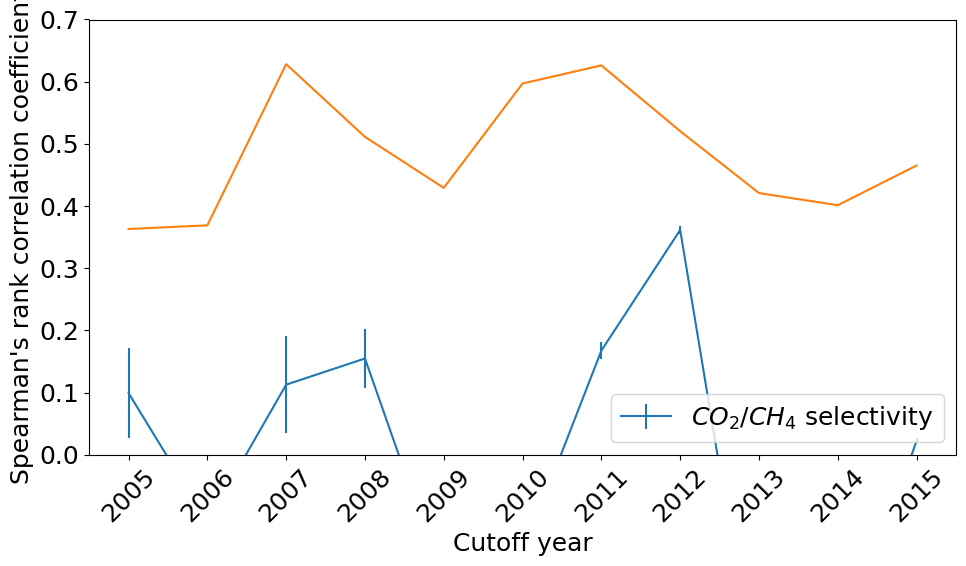

In [25]:
plt.figure(figsize=(10, 6))
years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

sp_sel_mean = [
    np.mean(sp_2005_sel),
    np.mean(sp_2006_sel),
    np.mean(sp_2007_sel),
    np.mean(sp_2008_sel),
    np.mean(sp_2009_sel),
    np.mean(sp_2010_sel),
    np.mean(sp_2011_sel),
    np.mean(sp_2012_sel),
    np.mean(sp_2013_sel),
    np.mean(sp_2014_sel),
    np.mean(sp_2015_sel)
]
sp_sel_std = [
    np.std(sp_2005_sel),
    np.std(sp_2006_sel),
    np.std(sp_2007_sel),
    np.std(sp_2008_sel),
    np.std(sp_2009_sel),
    np.std(sp_2010_sel),
    np.std(sp_2011_sel),
    np.std(sp_2012_sel),
    np.std(sp_2013_sel),
    np.std(sp_2014_sel),
    np.std(sp_2015_sel)
]

#plt.errorbar(years, sp_mean, sp_std, label="$CO_2\ k_H$")
plt.errorbar(years, sp_sel_mean, sp_sel_std, label="$CO_2/CH_4$ selectivity")
plt.plot(years,test_r2)
plt.xticks(years, labels=years, rotation=45)

plt.ylim([0, 0.7])
plt.xlabel("Cutoff year")
plt.ylabel("Spearman's rank correlation coefficient",)
plt.legend(loc='lower right')

plt.tight_layout()

#plt.savefig("../../../files/final_v/2-spearman.png", dpi=1200)